# The Inverse Transform

##### Keywords: sampling, inverse transform, CDF,  box-muller, normal distribution

## Contents
{:.no_toc}
* 
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## The idea

The basic idea behind the inverse transform method is to transform uniform samples into samples from a different distribution. That is, by somehow drawing from a uniform distribution, we make it possible to draw from the other distribution in question.

At first glance this seems to be a quixotic quest, but the key observation is this: the CDF of a distribution  is a function that ranges from  0 to 1. Now assume you  use $$Uniform(0,1)$$ to generate a random number, say 0.63. Now map this number on the range (or y-axis) to a x using the CDF curve to generate a sample. This process is illustrated below:

![](images/invtrans.png)

The right hand side image is the CDF while the left hand side is the pdf we want to sample from.

Notice that we randomly choose some samples from a uniform on the right hand side image and these correspond to  x's for the samples from the CDF.  On the left hand side we can see on the pdf the samples that these correspond to. If you sample from the uniform you will get more samples in the steep part of the cdf as the steep part of the cdf covers a good part of the probability values between 0 and 1. And thus you will get more samples in the higher parts of the pdf than elsewhere.

Clearly, for all this to work, we must be able to invert the cdf function, so that we can invert a uniform sample to get an $x$.

## Let us formalize this:

This is the process:

1. get a uniform sample $u$ from $Unif(0,1)$
1. solve for $x$ yielding a new equation $x=F^{-1}(u)$ where $F$ is the CDF of the distribution we desire. 
1. repeat.

Why does this work?

First note that:

$F^{-1}(u) = $ smallest x such that $F(x) >=u$

What distribution does random variable $y = F^{-1}(u)$ follow?

The CDF of y  is $p(y <= x)$. Since F is monotonic, we can without loss of generality write:

$$p(y <= x) = p(F(y) <= F(x)) = p(u <= F(x)) = F(x)$$

Thus we get the CDF and hence the pdf that we want to sample from!

### Example: Draw from the distribution $f(x) \sim \exp{(-x)}$


 For example, lets assume we would like
to generate random numbers that follow the exponential distribution
$f(x) = \frac{1}{\lambda} e^{-x/\lambda}$ for $x\ge0$ and $f(x)=0$ 
otherwise. Following the recipe from above

$$ u = \int_{0}^{x} \frac{1}{\lambda} e^{-x'/\lambda} dx'  = 1- e^{-x/\lambda} $$ 

Solving for $x$ 
$$ x = - \lambda \ln (1-u) $$





Now we want the exponential with $\lambda = 1$. The following code will produce numbers that follow this $\exp{(-x)}$ distribution. The figure
generated by code below shows the resulting histogram of the generated numbers
compared to the actual $\exp{(-x)}$.

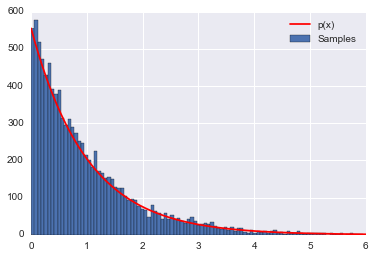

In [3]:
# probability distribution we're trying to calculate
p = lambda x: np.exp(-x)

# CDF of p
CDF = lambda x: 1-np.exp(-x)

# invert the CDF
invCDF = lambda r: -np.log(1-r)

# domain limits
xmin = 0 # the lower limit of our domain
xmax = 6 # the upper limit of our domain

# range limits
rmin = CDF(xmin)
rmax = CDF(xmax)

N = 10000 # the total of samples we wish to generate

# generate uniform samples in our range then invert the CDF
# to get samples of our target distribution
R = np.random.uniform(rmin, rmax, N)
X = invCDF(R)

# get the histogram info
hinfo = np.histogram(X,100)

# plot the histogram
plt.hist(X,bins=100, label=u'Samples');

# plot our (normalized) function
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, hinfo[0][0]*p(xvals), 'r', label=u'p(x)')

# turn on the legend
plt.legend()


### Box-Muller algorithm

In many cases the integral to calculate the CDF may not be easy to calculate analytically
and we need to come with clever algorithms. For example 
there is no closed form formula for the integral of the normal distribution
$ I=\frac{1}{2\pi} \int_{-\infty}^{x} e^{-x'^2/2}dx' $.

The Box Muller method is a brilliant trick to overcome this by producing two independent standard normals
from two independent uniforms. 

The idea is this:

Consider  (without loss of generality) the  product of two independent normals N(0,1):

$$ X \sim N(0,1), Y \sim N(0,1) \implies X,Y \sim N(0,1)N(0,1)$$

The pdf then is:

$$f_{XY}(x,y)  =  \frac{1}{\sqrt{2\pi}} e^{-x^2/2} \times \frac{1}{\sqrt{2\pi}} e^{-y^2/2} = \frac{1}{2\pi} \times e^{-r^2/2}$$

where $r^2 = x^2 + y^2$.

If you think of this in terms of polar co-ordinates $r$ and $\theta$, we have

$$\Theta \sim Unif(0, 2\pi),  S = R^2 \sim Exp(1/2)$$

From the inverse method for the exponential above:

$$ s = r^2 = -2 ln(1-u) $$

where u is a sample from $U \sim Unif(0,1)$. Now if $U \sim Unif(0,1)$, then $1-U \sim Unif(0,1)$.

Thus  we can write:

$$r = \sqrt{-2\,ln(u_1)}, \theta = 2\pi\, u_2$$

where $u_1$ and $u_2$ are both drawn from a $Unif(0,1)$s.

Now we can use:

$$x = r\,cos\theta, y = r\,sin\theta$$

to generate samples for the normally distributed random variables $x$ and $Y$.

We've hand-waved around a bit here in this derivation, so let us ask, what is the pdf in polar co-ordinates? Lets make a few observations.

1. clearly, no matter what co-ordinates we use $\int dF =1$. In other words, no matter how we add slivers, the probabilities in these slivers must add to 1.
2. one can think of cartesian co-ordinate slivers being histogram skyscrapers on a regular grid. In polar co-ordinates the slivers are arranged radially
3. We have in terms of the pdfs:

$$\int dx dy f(x,y) = \int dr d\theta f2(r, \theta) = \int dr d\theta f2r(r)\, f2t(\theta)$$

And we have seen:

fpolar(\theta) =Unif(0, 2\pi)

We might be tempted to think that $f2r(r) = e^{-r^2/2}$. But this is not correct on two counts. First, its not even dimensionally right. Secondly, then you transform the $dxdy$ to polar , you get $rdrd\theta$.

What this means is that :

$$f2r(r) = re^{-r^2/2}$$

This is called the Raleigh distribution.

And now you can see how the transformation $s=r^2$ gives us an exponential in s. And this is why we could take $R^2 \sim Exp(1/2)$ without much ado..the exponential happily normalizes out to 1 dur to the $r$ multiplying the exponential in the pdf above.

More generally, if $z=g(x)$ so that $x=g^{-1}(z)$, let us define the Jacobian $J(z)$ of the transformation  $x=g^{-1}(z)$ as the partial derivatives matrix of the transformation.

Then:

$$f_Z(z) = f_X(g^{-1}(z)) \times det(J(z))$$

We can work this out with $z$ the polar co-ordinates and  $g^{-1}$ as $x=r\,cos(\theta)$ and $y=r\,sin(\theta)$, with $g$ as $r=\sqrt{x^2 + y^2}$, $tan(\theta) = y/x$.

$$ J =  \binom{cos(\theta)\:sin(\theta)}{-r sin(\theta)\:r cos(\theta)}$$

whose determinant is  $r$,  and thus

$$f_{R, \Theta}(r, \theta) = f_{X,Y}(r cos(\theta), r sin(\theta)) \times r =  \frac{1}{\sqrt{2\pi}} e^{-(r cos(\theta))^2/2} \times \frac{1}{\sqrt{2\pi}} e^{-(r sin(\theta))^2/2} = \frac{1}{2\pi} \times e^{-r^2/2} \times r$$.